# *Ongoing Questions*


1. GUI/Server Implementation:
  - Are we responsible for GUI or server implementation? That is, are we working with APIs and cloud-based infrastructure?
      - no
  - Do we want the output to be the individual 3D floor plan or a stacked layer of floor plans that represents the building in the GUI?
      - stacked layer of floor plans
2. Verify Hesistancy about the Blueprint Data:
 - How do you want to deal with notes/scratch work on the floor plans? Should we just blur/remove them out?
    - Incorporate additional information into the CV algorithms to detect. Features like text and dimensions could be important.
 - Does "3rd to 6th floor plan" mean they're the same 3 floor plans when stacking (copy + paste)?
    - yes
 - Do we want to include the roof plans?
    - yes
 - What's the difference between typical, mechanical, electrical, and plumbing floor plans?
    - We want to combine all features from each multimodal floor plan
 - What set of features are we hoping to focus on/prioritize for 3D modeling?
    - features that are not limited to the legends that are shown
 - Are we hoping to stack the generated 3D floorplan models? Does that mean that the input will be several floor plan images into the GUI?
    - yes. output should be a stacked 3D floor model showing the different, but valuable features to stakeholders
 - Are there preferred image dimensions for 3D model generation?

# Types of CV Models

## Image Processing Model

1. Input image is read using library like OpenCV.
2. Image is converted into binary format for noise removal.
3. Erosion + Dilation is performed to reduce noise.
4. The walls will be detected by foreground and background segmentation.
5. \# of walls will be detected using contour detection and will store the coordinates for rendering a 3D model.

## 3DPlanNet Model

1. Input image is read
2. Pattern recognition is needed to recognize variety of walls
3. Then apply object detection for information including doors, windows, furniture, materials, dimensions, and text. This means a detection algorithm for each object/feature. Libraries could include TensforFlow object detection API
4. Then node + edge generation is created through the information analyzed from the previous step
5. Object generation is final part that generates the 3D model in the form of 3D mesh objects

## Blender3D

https://github.com/grebtsew/FloorplanToBlender3d?tab=readme-ov-file

Floorplan to blender library called FTBL that converts images into 3D models.

1. Implement Blender3D and import model to CAD (?)
2. Figure out image preprocessing stages
3. Research which models have potential
4. Establish flowchart/pipeline for 2d to 3d generation

# Metrics to Evaluate


1. 2D to 3D Floor plan Modeling using Image Processing and Augmented Reality
- "The accuracy of a 3D model is determined by the accuracy
of the algorithm used to recognize the floor plan image. This
accuracy is calculated by dividing the number of walls that
have been accurately placed in the 3D model by the total
number of walls in the original image. To improve the accuracy
of the model, the algorithm used to recognize the floor plan
image should be fine-tuned to ensure that the walls in the 3D
model are accurately placed in the right locations"

- "We also measured the accuracy improvement when furniture and text were added to the floor plan. We found that the algorithm performed significantly better with these elements included, indicating that they can be used to enhance the accuracy of the algorithm."

- "We found that adding textual or semantic information can
significantly improve the accuracy of recognition, allowing
us to gain further context as to what classifies as a room.
By incorporating this information, we were able to improve
the recognition performance and better distinguish between
different types of rooms."

\\

2. 3DPlanNet: Generating 3D Models from 2D Floor Plan Images
Using Ensemble Methods
- "Naturally, how accurately the information can be extracted greatly affects the performance of the 3D vector models transformation. In the wall pattern recognition step, since recognition was performed excluding the door/window area, we needed to recognize the door/window area in order to increase accuracy."

# Bibliography

1. 2D to 3D Floor plan Modeling using Image
Processing and Augmented Reality (Deshmukh et al.)
2. 3DPlanNet: Generating 3D Models from 2D Floor Plan Images
Using Ensemble Methods (Park and Kim)
3. https://github.com/grebtsew/FloorplanToBlender3d?tab=readme-ov-file
4. Vectorizing Building Blueprints (Song et al.)
5. Towards Robust Object Detection in Floor Plan Images: A Data Augmentation Approach (Mishra et al.)

# **Code**

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install PyMuPDF Pillow
!pip install opencv-python

In [7]:
# computer vision
import fitz
import cv2
from google.colab.patches import cv2_imshow

# miscellaneous
import numpy as np
import os
import matplotlib.pyplot as plt

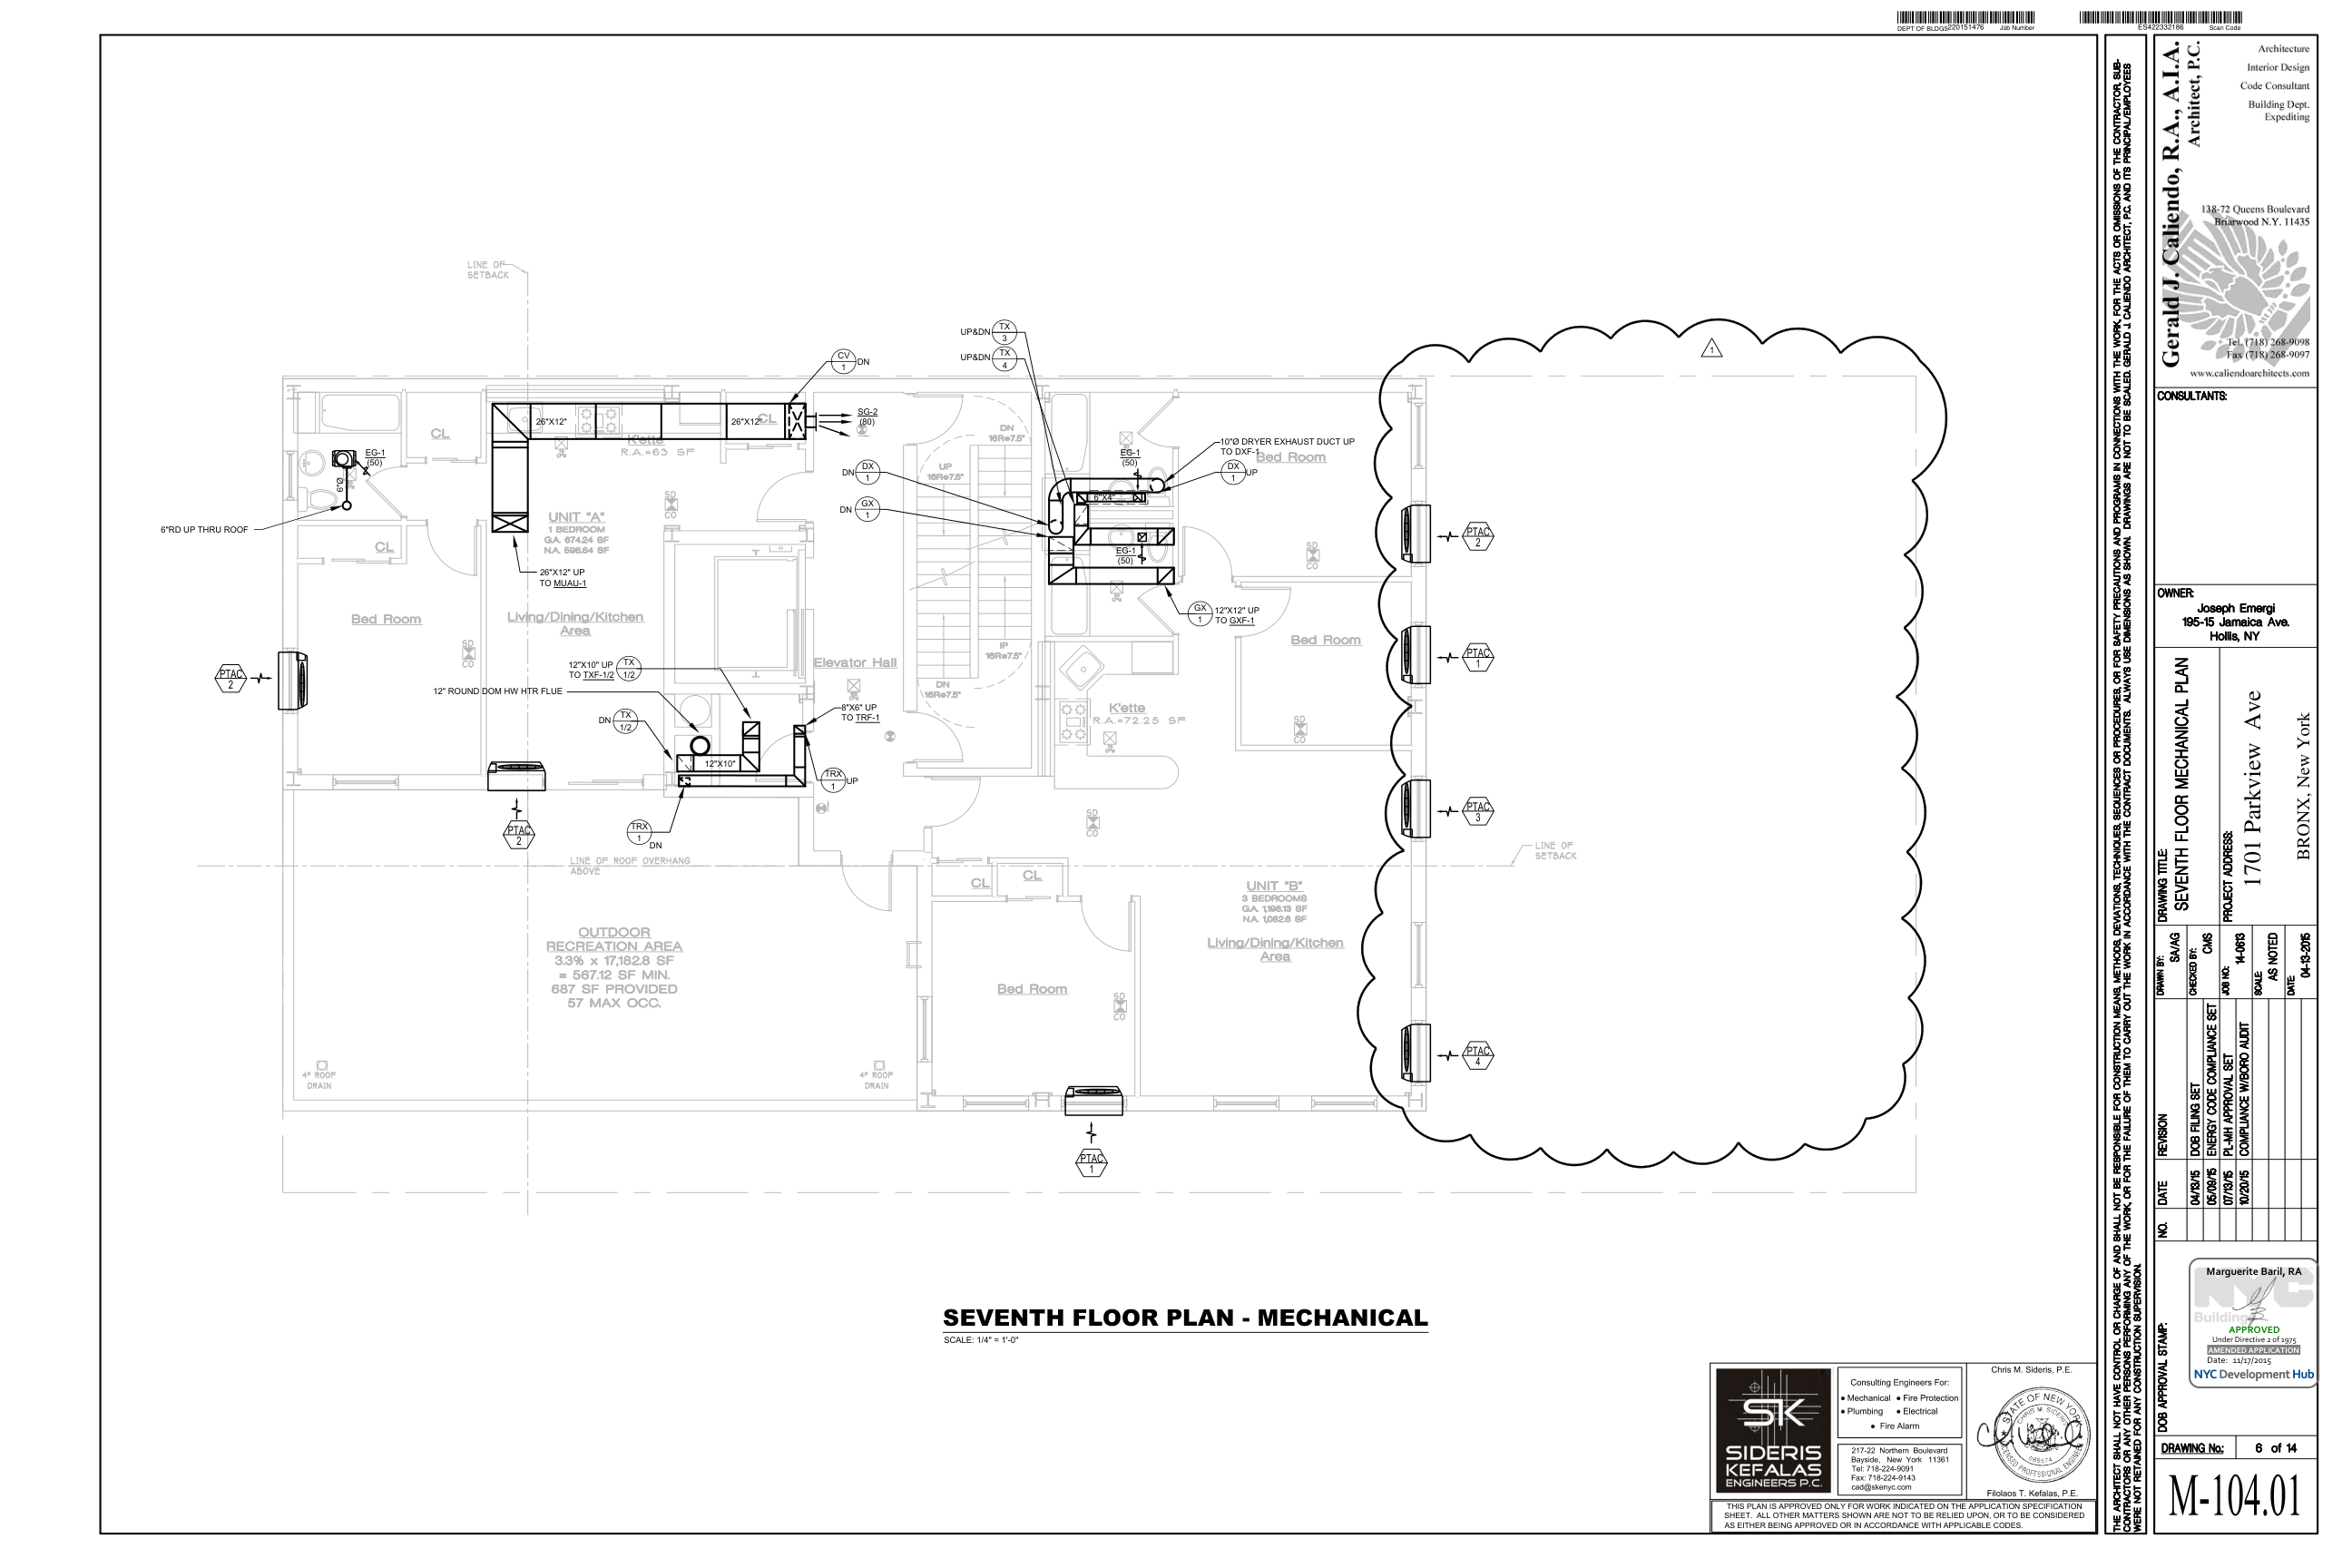

In [143]:
# Load the image using OpenCV
image_path = '/content/drive/MyDrive/*Datasets/Parkview Data Images/page_52.png'
img = cv2.imread(image_path)

# Display the image using cv2_imshow (for Google Colab)
cv2_imshow(img)

We want to be able to **(1) isolate the floor plan layout and extract plan type**, **(2) detect features shown from the each set of legends**, and **(3) create reference system for edge detection and scaling**

# Isolating Floor Plan Layout

**How can you extract the floor plan class type before isolating that section of the image?**

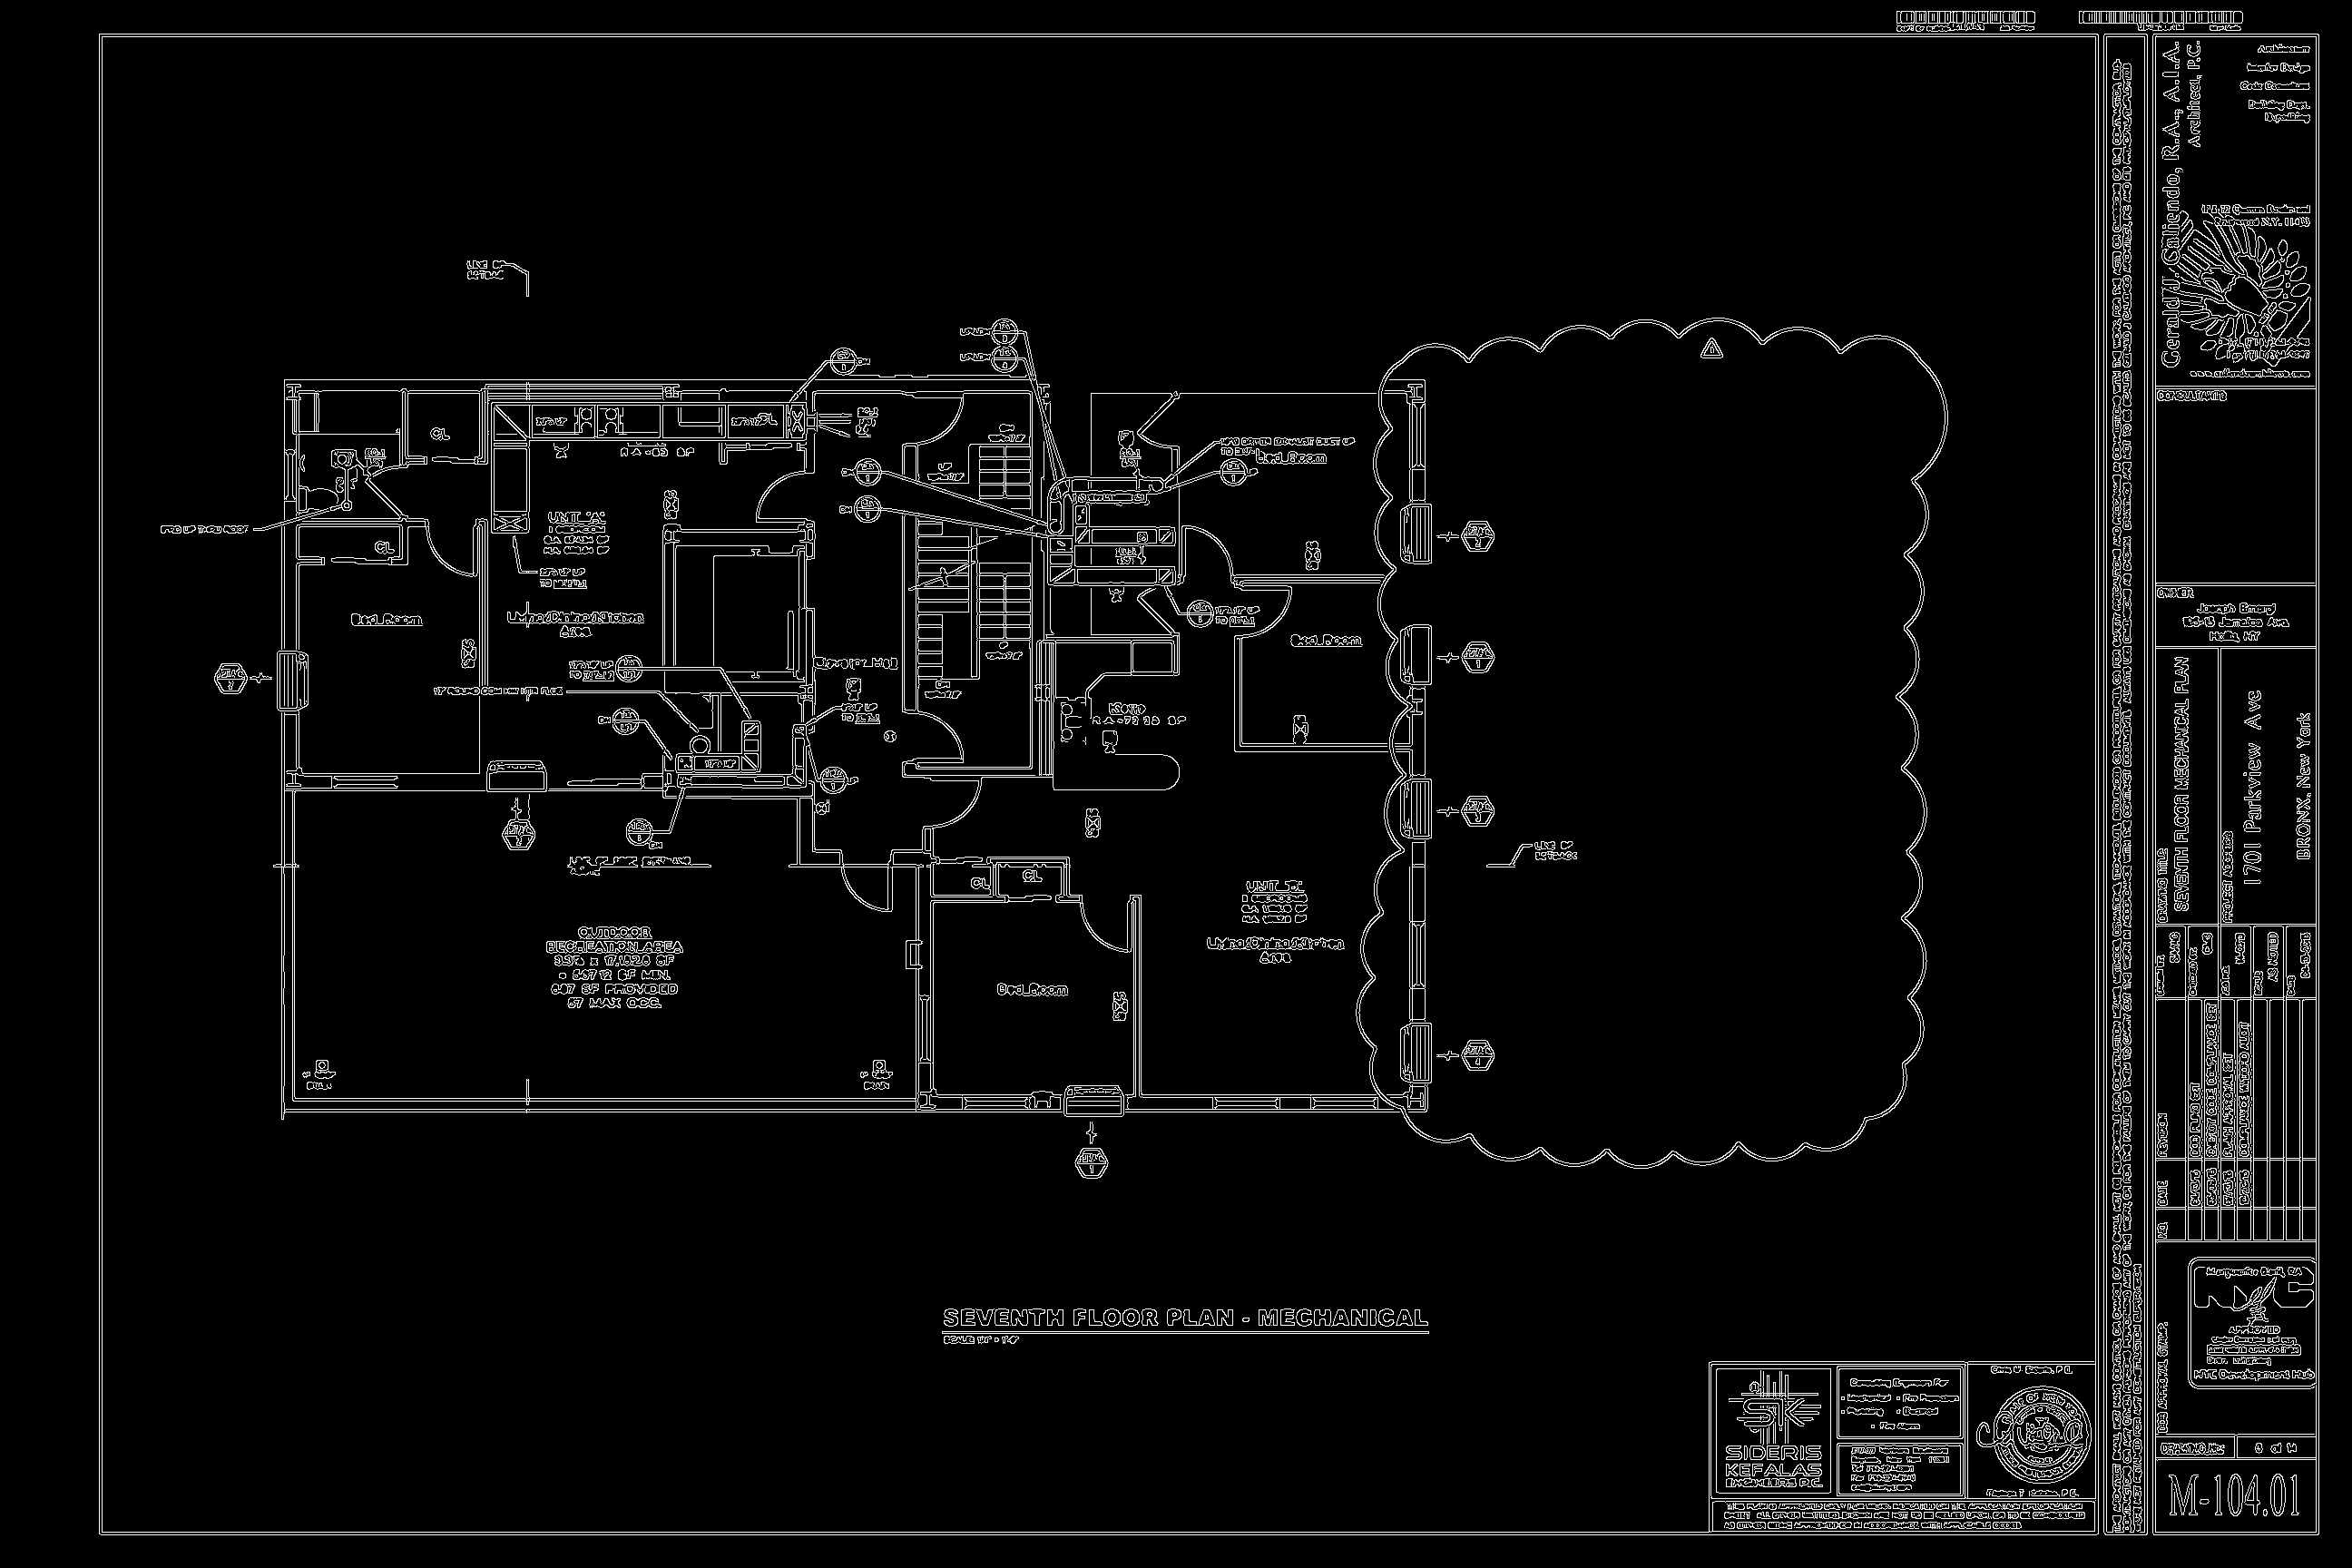

In [144]:
# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Use Canny edge detection
edges = cv2.Canny(blurred, 50, 150)

cv2_imshow(edges)

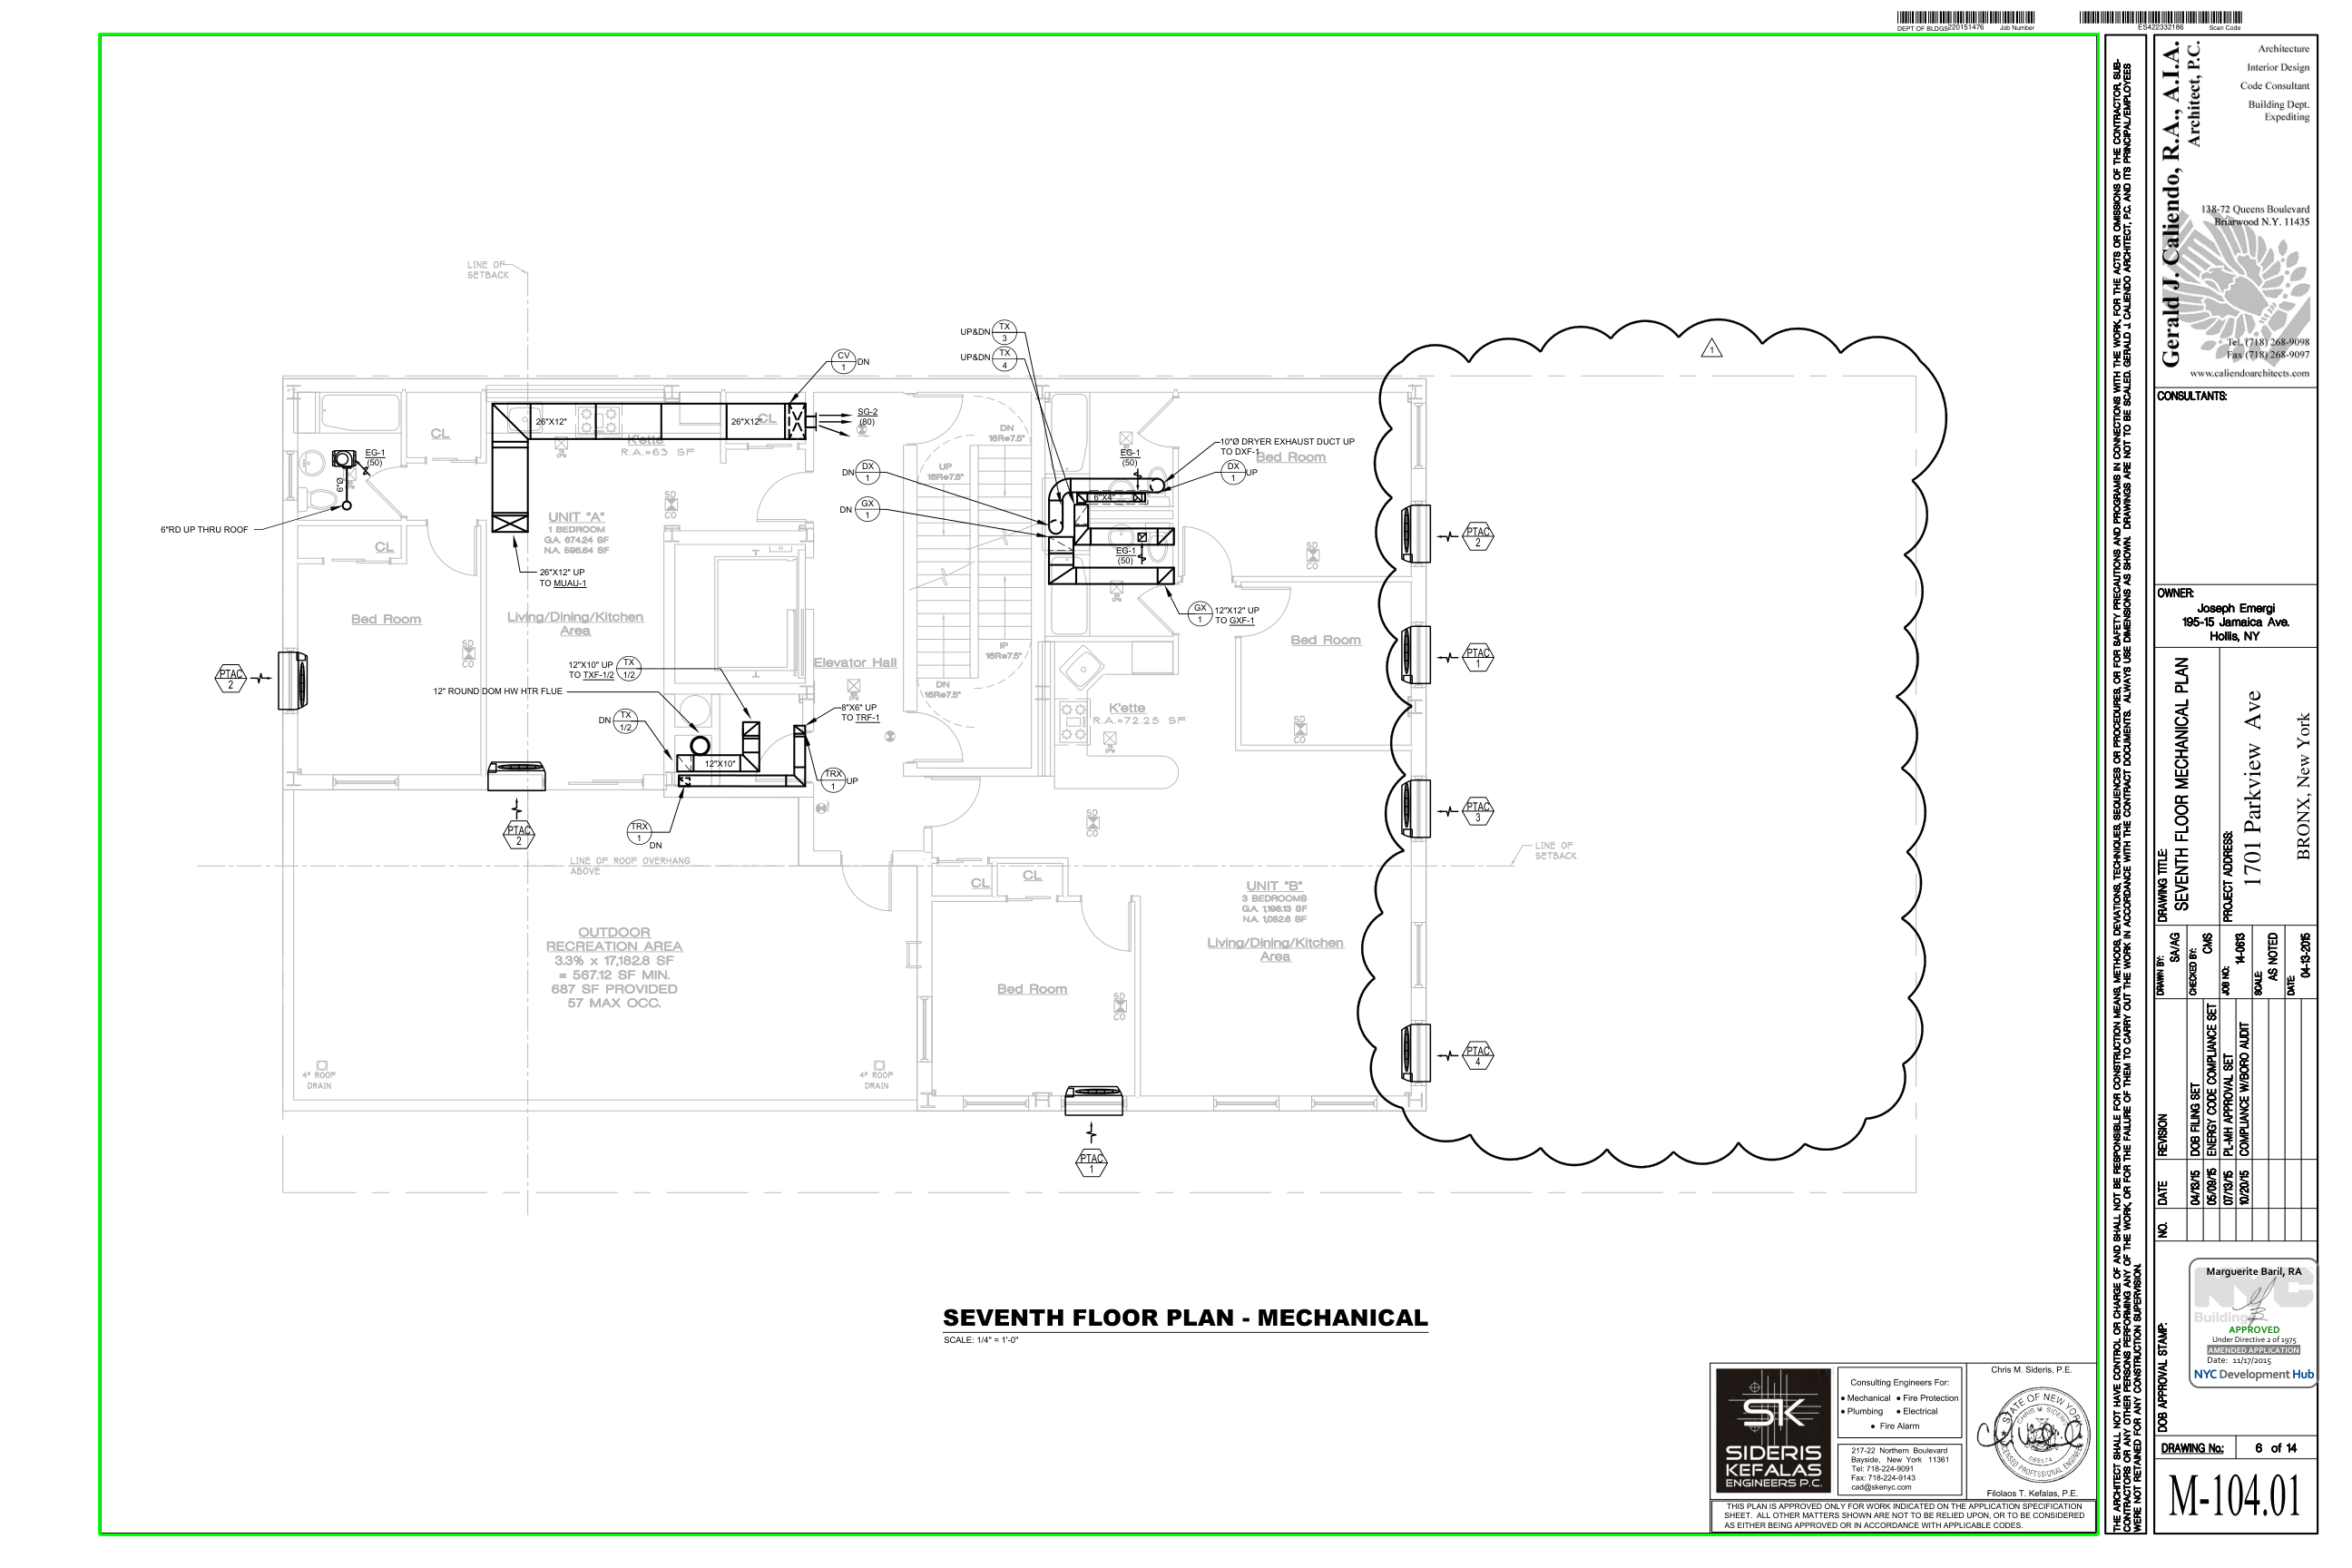

In [145]:
# Find contours in the edge-detected image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort the contours by area to find the largest one (which should be the floor plan)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Draw the largest contour on a copy of the image (for visualization)
contour_image = img.copy()
cv2.drawContours(contour_image, contours, 0, (0, 255, 0), 2)

cv2_imshow(contour_image)

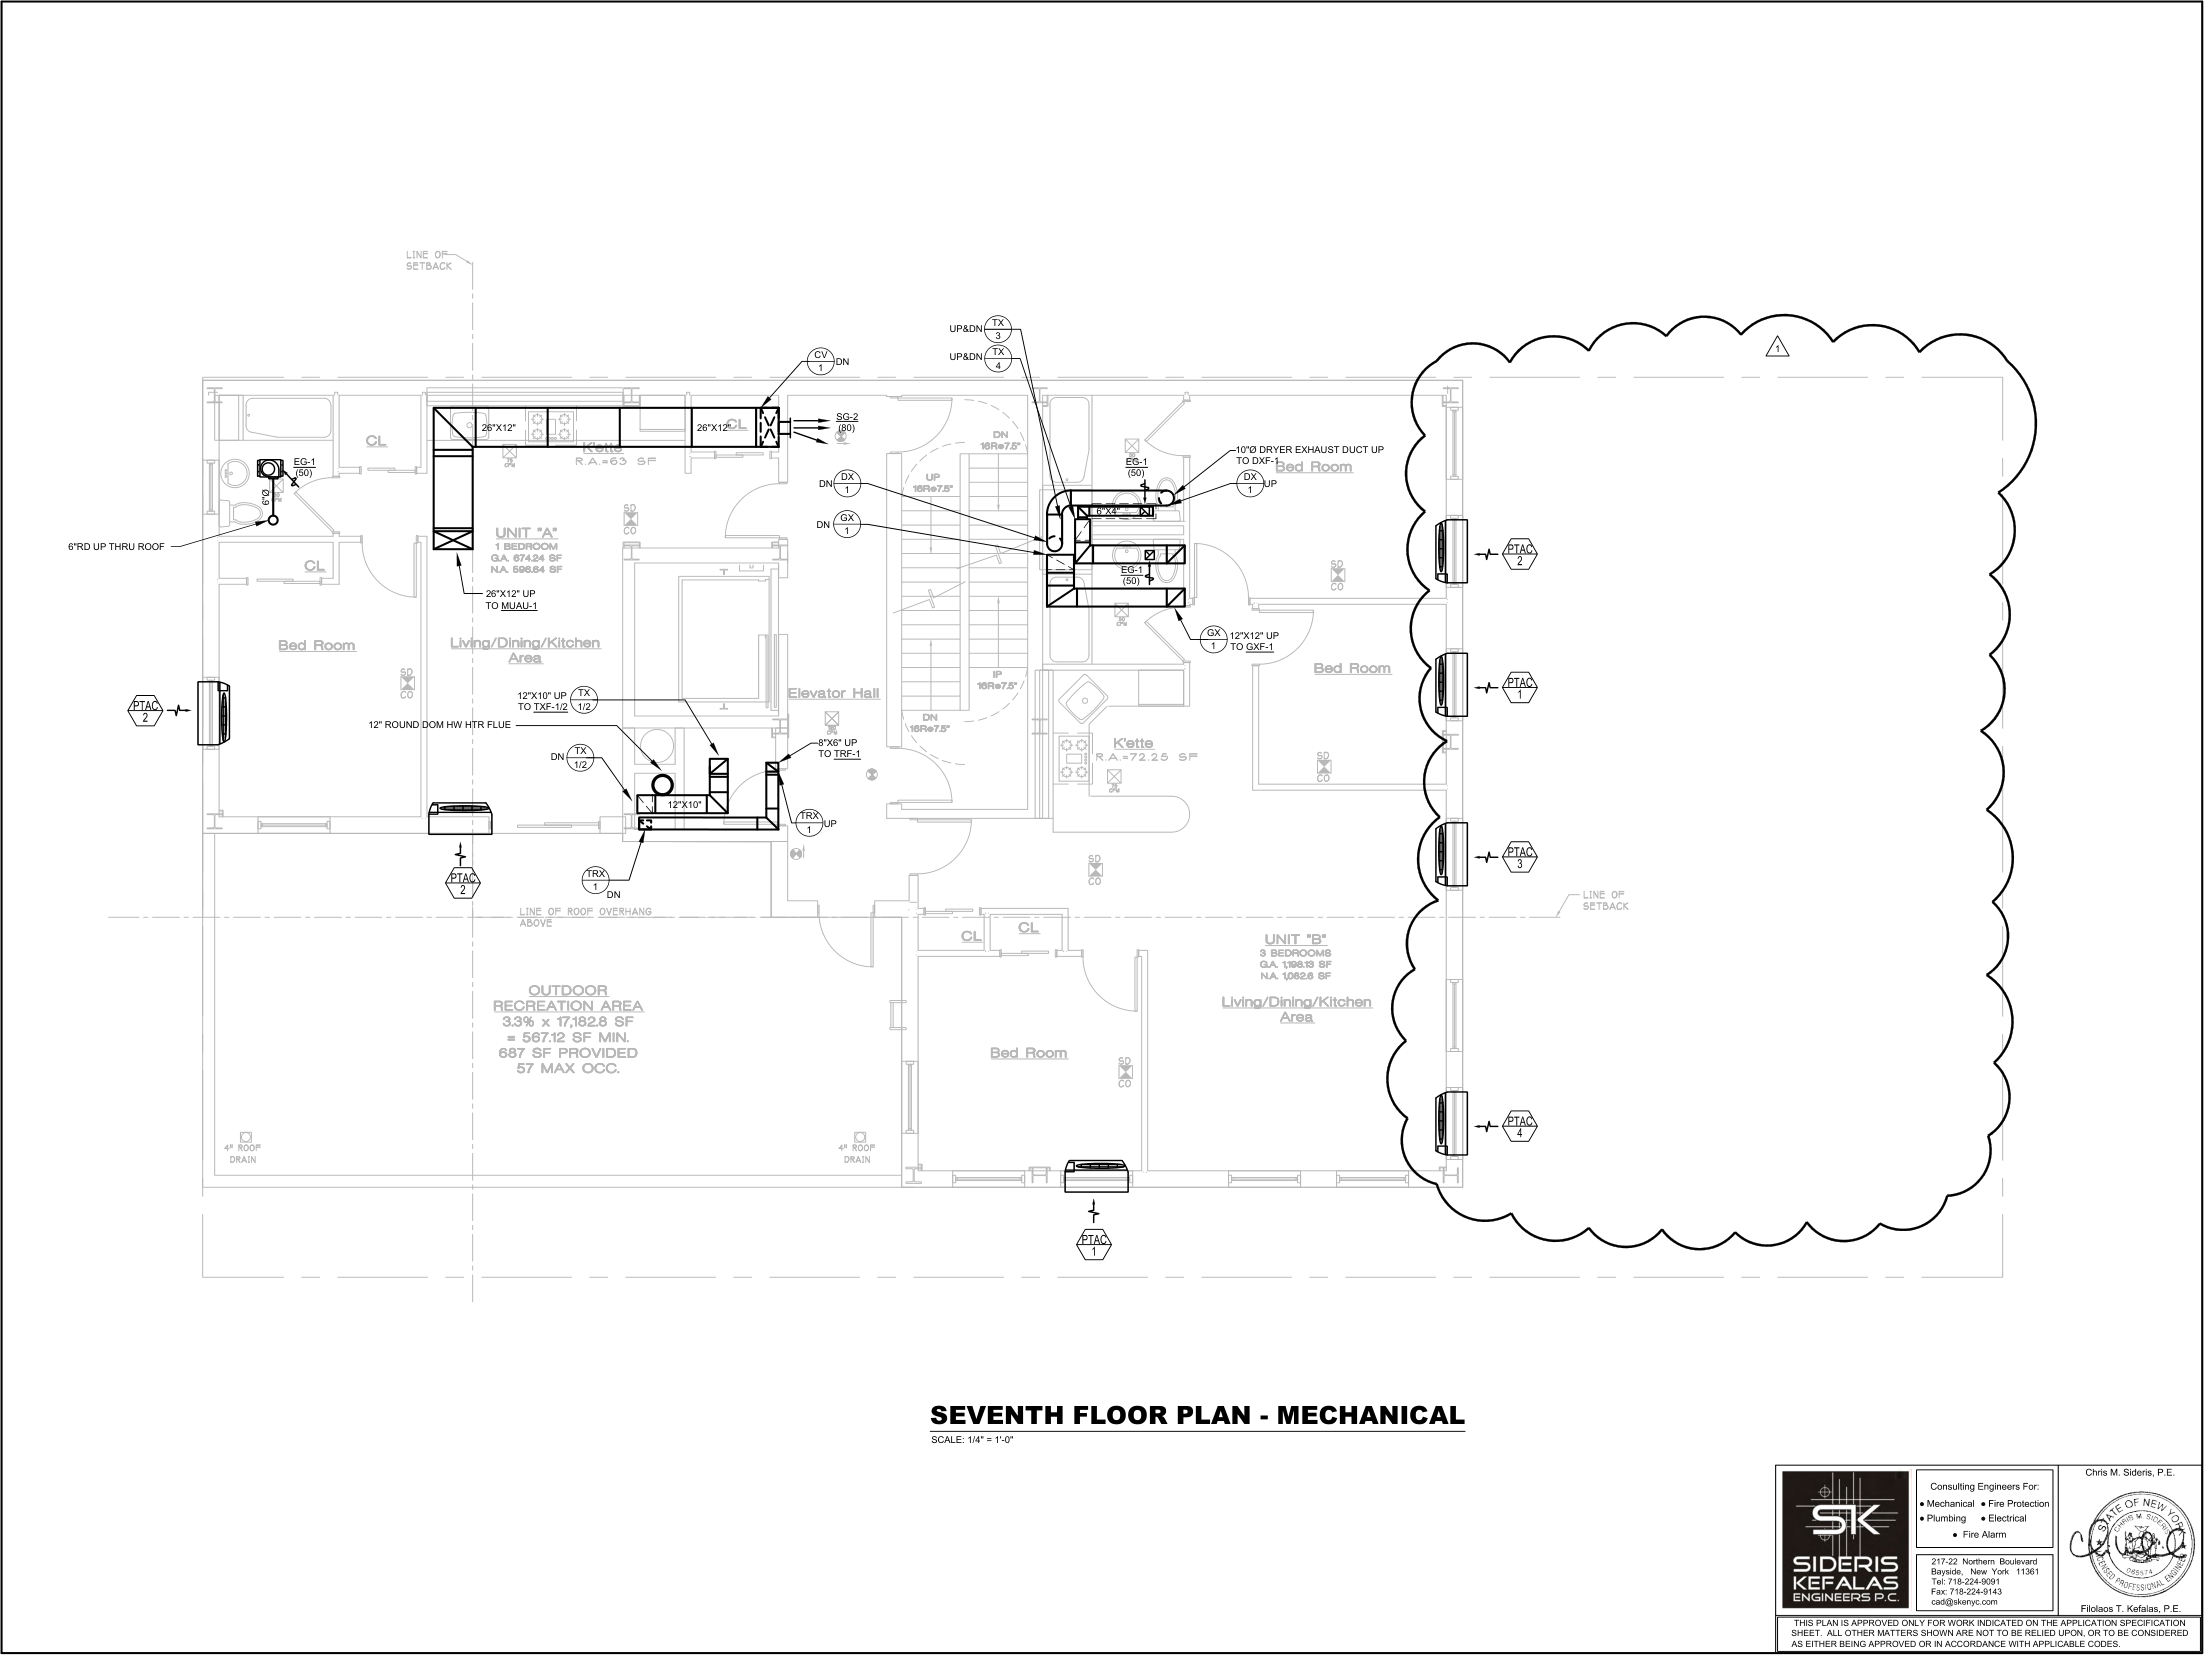

In [146]:
# Variables to hold the best floor plan contour
best_contour = None
height, width = img.shape[:2]

# Loop through contours to find the best candidate for the floor plan layout
for contour in contours:
    # Get the bounding box for each contour
    x, y, w, h = cv2.boundingRect(contour)

    # Calculate aspect ratio and area of the bounding box
    aspect_ratio = w / float(h)
    area = w * h

    # Exclude smaller area and aspect ratio contours
    if area > 50000 and 1.0 < aspect_ratio < 2.5:
        # this ensures that the sidebar to the right is removed
        if x + w < 0.9 * width:
            best_contour = contour
            break

# Draw the best contour on the image (for visualization)
if best_contour is not None:
    # Get bounding box of the best contour and crop the floor plan layout
    x, y, w, h = cv2.boundingRect(best_contour)
    cropped_floor_plan = img[y:y+h, x:x+w]
    cv2_imshow(cropped_floor_plan)

# Template Matching for Feature Detection using Legends

We are first starting with mechanical floor plan types, but will have to include the other legends as well

## Mechanical Floor Plans

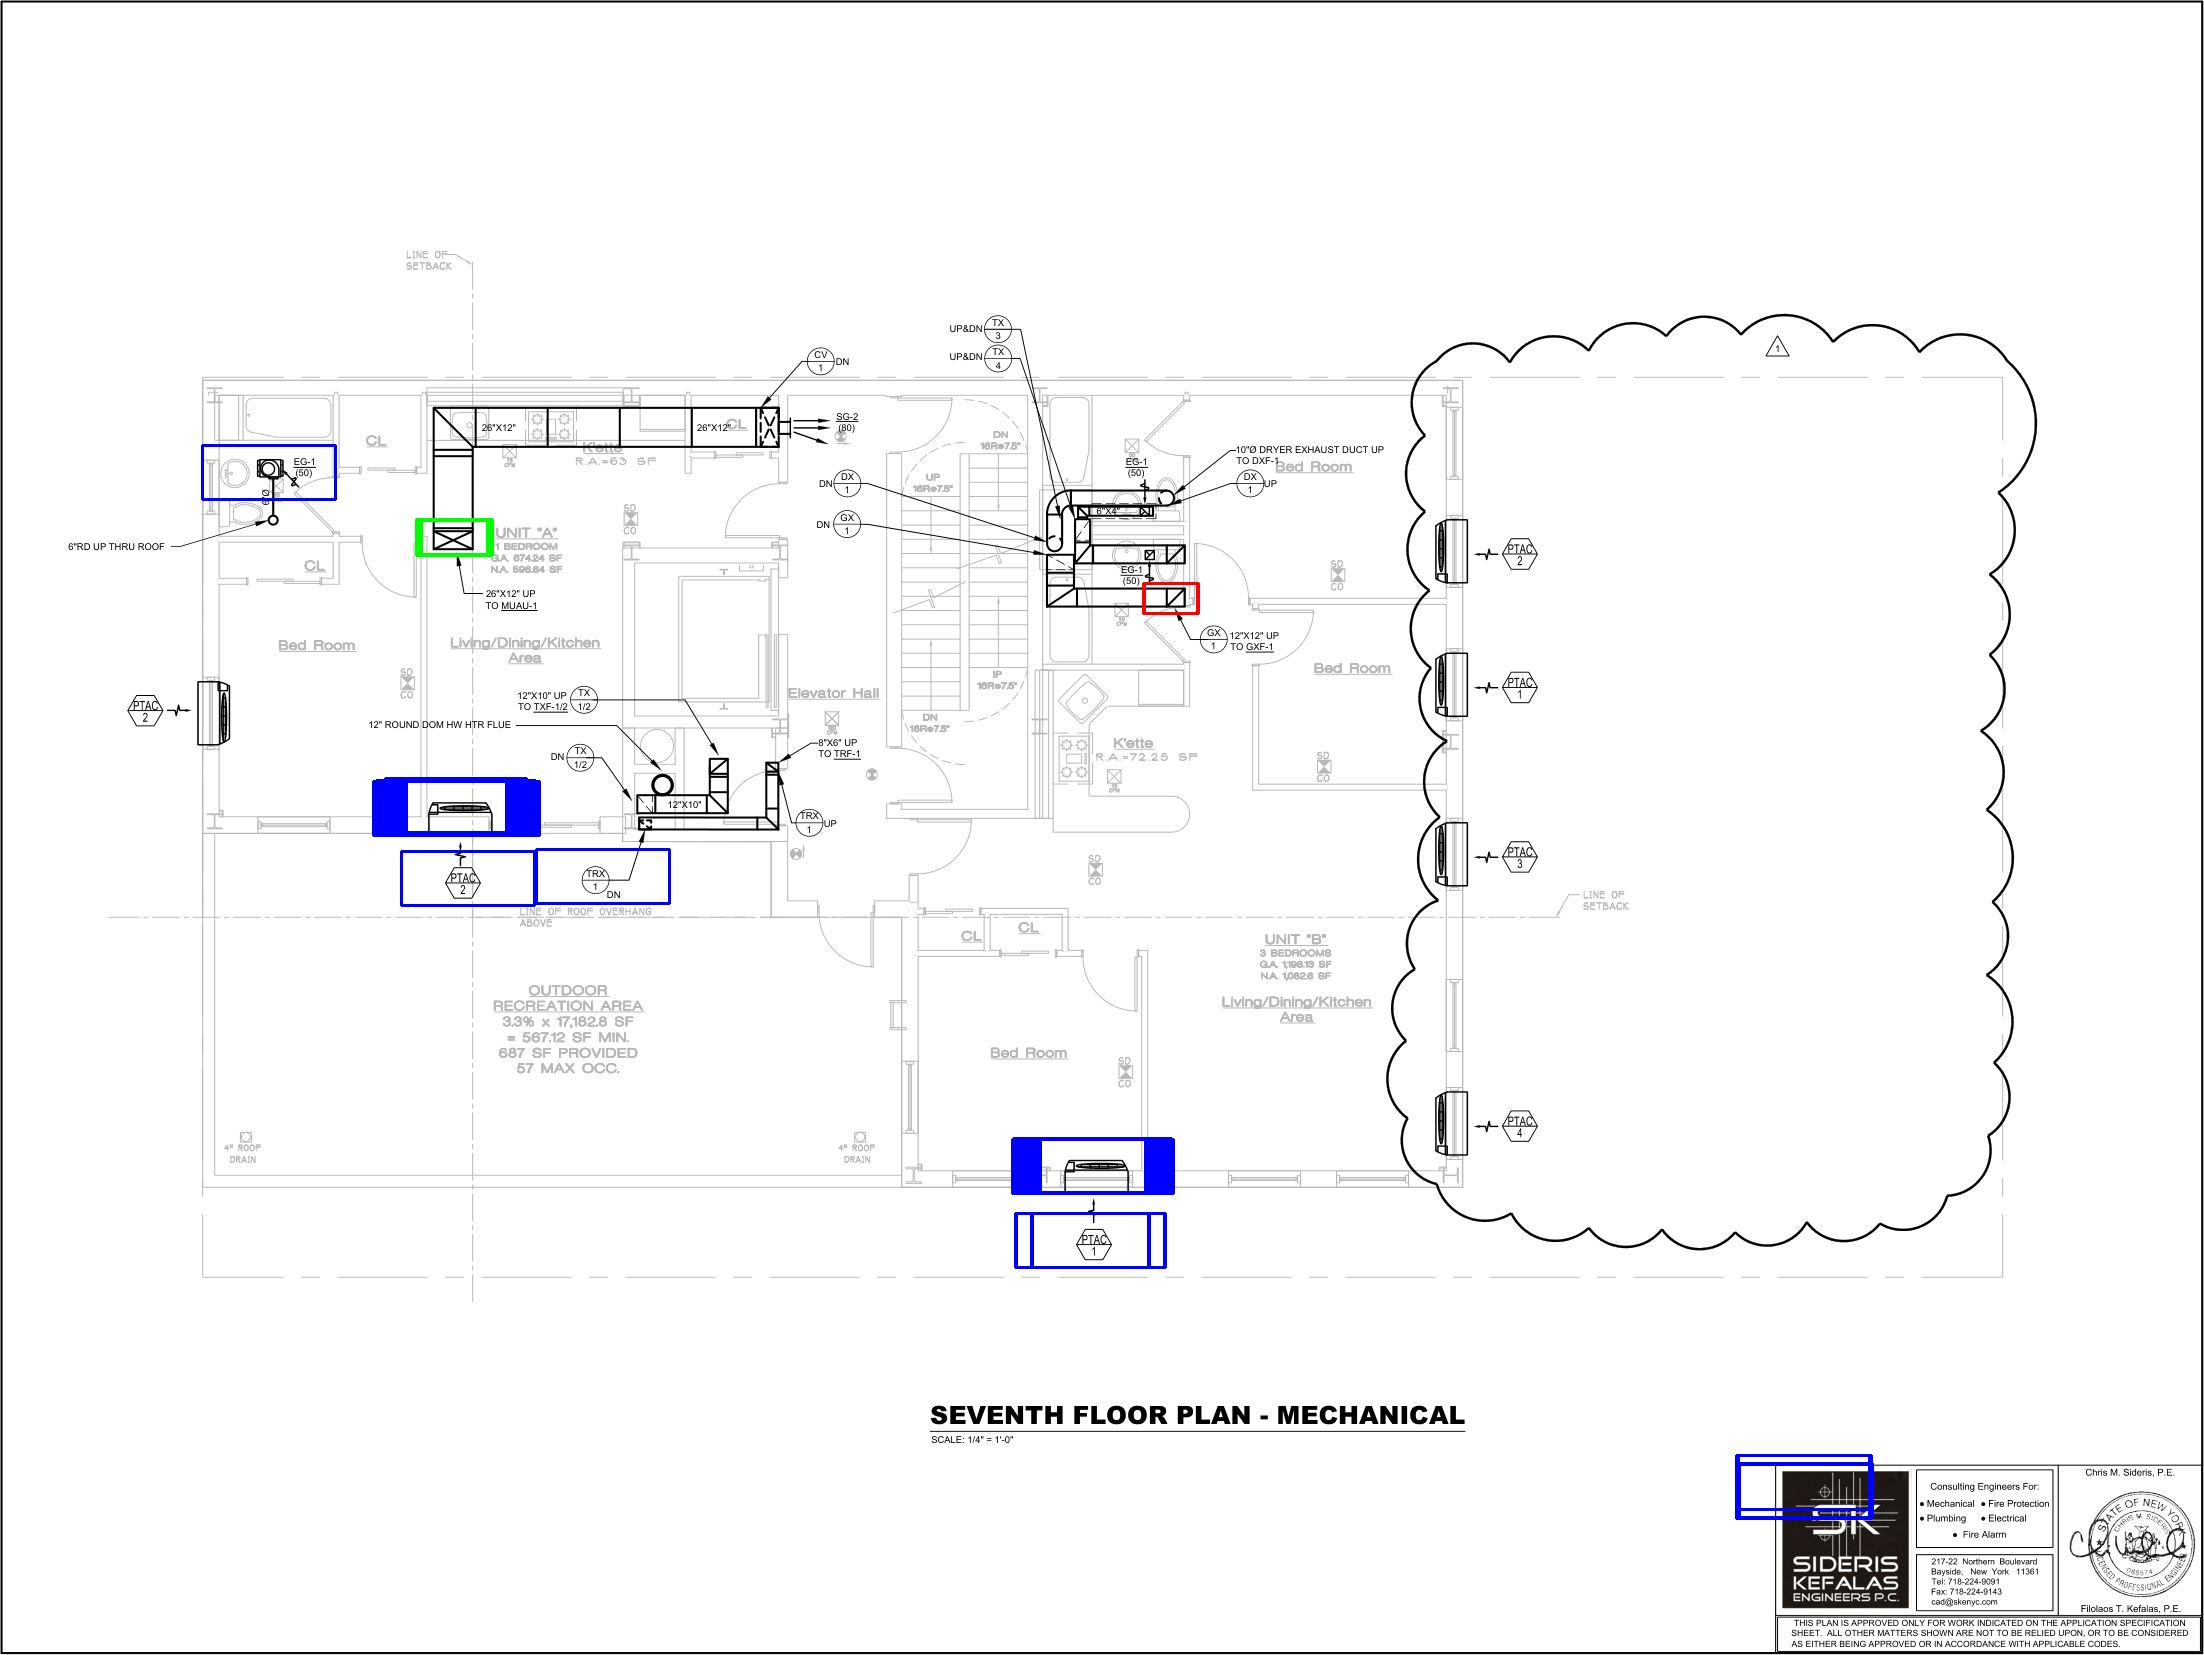

In [147]:
def mechanical_feature_detector(image):
    """
    Detects mechanical features in a given floor plan image using template matching.

    Args:
    image: Grayscale image of the floor plan where features need to be detected.

    Returns:
    image: The original image with detected features highlighted.
    """
    #################### Supply Air Duct ####################
    symbol_sad = cv2.imread('/content/Supply Air Duct.png')
    symbol_sad_gray = cv2.cvtColor(symbol_sad, cv2.COLOR_BGR2GRAY)

    # Perform template matching
    result = cv2.matchTemplate(image, symbol_sad, cv2.TM_CCOEFF_NORMED)

    # Locate points where the match exceeds the threshold
    threshold = 0.5
    loc = np.where(result >= threshold)

    # Dimensions of the template
    h, w = symbol_sad_gray.shape[:2]

    # Draw rectangles around detected symbols
    for pt in zip(*loc[::-1]):  # Switch x and y coordinates
        cv2.rectangle(image, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

    ######################################################################
    #################### Return Air Duct ####################

    symbol_template_return = cv2.imread('/content/Return Air Duct.png')
    symbol_template_return_gray = cv2.cvtColor(symbol_template_return, cv2.COLOR_BGR2GRAY)

    # Perform template matching
    result_return = cv2.matchTemplate(image, symbol_template_return, cv2.TM_CCOEFF_NORMED)

    # Locate points where the match exceeds the threshold for Return Air Duct
    threshold_return = 0.5  # Adjust threshold if needed for the Return Air Duct
    loc_return = np.where(result_return >= threshold_return)

    # Dimensions of the Return Air Duct template
    h_return, w_return = symbol_template_return_gray.shape[:2]

    # Draw rectangles around detected symbols for Return Air Duct
    for pt in zip(*loc_return[::-1]):  # Switch x and y coordinates
        cv2.rectangle(image, pt, (pt[0] + w_return, pt[1] + h_return), (0, 0, 255), 2)  # Use different color for differentiation

    ######################################################################
    #################### PTAC ####################

    symbol_ptac = cv2.imread('/content/1_PTAC.png')
    symbol_ptac_gray = cv2.cvtColor(symbol_ptac, cv2.COLOR_BGR2GRAY)

    # Perform template matching
    result_ptac = cv2.matchTemplate(image, symbol_ptac, cv2.TM_CCOEFF_NORMED)

    # Locate points where the match exceeds the threshold for PTAC
    threshold_ptac = 0.3  # Adjust threshold if needed for PTAC
    loc_ptac = np.where(result_ptac >= threshold_ptac)

    # Dimensions of the PTAC template
    h_ptac, w_ptac = symbol_ptac_gray.shape[:2]

    # Draw rectangles around detected symbols for PTAC
    for pt in zip(*loc_ptac[::-1]):  # Switch x and y coordinates
        cv2.rectangle(image, pt, (pt[0] + w_ptac, pt[1] + h_ptac), (255, 0, 0), 2)  # Use another color for differentiation

    ######################################################################

    return image

detected_image = mechanical_feature_detector(cropped_floor_plan)
cv2_imshow(detected_image)

# Reference System

At least for now since I've been working with them, mechanical and plumbing have the same scale of 1/4 inch = 1 foot.

What is the proper way to create conversion scale? Should you consider pixels if there is no alternative?